We want to visualize the distributional shifts between MIMIC-III and MIMIC-IV 

In [1]:
import sys
import getpass
user_id = getpass.getuser()
sys.path.append(f"/home/{user_id}/projects/OTTEHR/")

import matplotlib.pyplot as plt
from mimic_common import *
import numpy as np
import os
import pandas as pd
from scipy import stats

2025-02-18 13:17:09.352209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739913429.379273 2292614 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739913429.388304 2292614 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def custom_train_reps(source_features, target_features, n_components, pca_explain=False):
    """ 
    Customized training algorithm for generating target representations and source representations

    In the cross database experiments, we run PCA separately on source and target, and use Gromov Wasserstein OT to enable transfer learning

    :param bool pca_explain: print the explained variance of each components
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=n_components)
    source_reps = source_pca.fit_transform(source_features)

    # When using gromov Wasserstein OT, we can use different PCA to embed source and target features 
    target_pca = PCA(n_components=n_components)
    target_reps = target_pca.fit_transform(target_features)

    if pca_explain:
        source_exp_var = source_pca.explained_variance_ratio_
        source_cum_sum_var = np.cumsum(source_exp_var)
        target_exp_var = source_pca.explained_variance_ratio_
        target_cum_sum_var = np.cumsum(target_exp_var)
        print("Cummulative variance explained by the source PCA is:", source_cum_sum_var[-1])
        print("Cummulative variance explained by the target PCA is:", target_cum_sum_var[-1])

    return source_reps, target_reps

In [3]:
# Set parameters for this task
n_components = 50

suffix = None

group_name = 'version'
source = 'mimic_iv'
target = 'mimic_iii'

source_count = 10000
target_count = 10000

# trans_metric = 'OT'
trans_metric = 'GWOT'
output_dir = cross_output_dir
input_name = 'ICD codes'
output_name = 'duration'
type = 'cat'


In [4]:
# Read in dataframe
full_df = pd.read_csv(os.path.join(output_dir, "admission_patient_diagnosis_ICD.csv"), index_col=None, header=0, converters={'ICD codes': literal_eval})
selected_df = select_samples(full_df, group_name, type, source, target, source_count=source_count, target_count=target_count)

source_features, source_labels, target_features, target_labels = gen_code_feature_label(selected_df, group_name, type, source, target, input_name, output_name)

source_reps, target_reps = custom_train_reps(source_features, target_features, n_components)



number of target indices is: 58929 target_count is: 10000
number of source indices is: 545497 source_count is: 10000
number of codes is: 10499


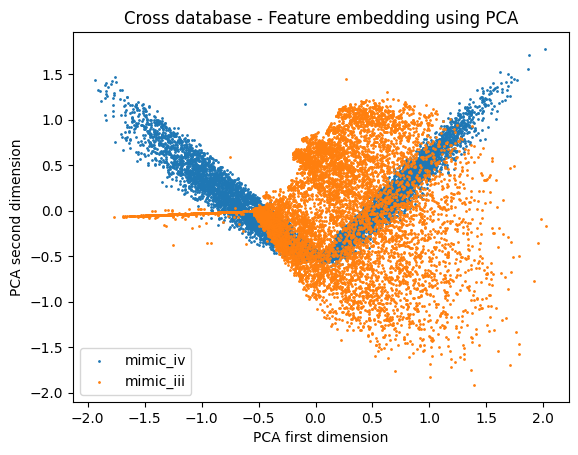

In [5]:
plt.scatter(source_reps[:, 0], source_reps[:, 1], label=source, s=1)
plt.scatter(target_reps[:, 0], target_reps[:, 1], label=target, s=1)
plt.xlabel('PCA first dimension')
plt.ylabel('PCA second dimension')
plt.title('Cross database - Feature embedding using PCA')
plt.legend()
# plt.savefig(os.path.join(output_dir, f"{group_name}_distn_shift.pdf"))

Conduct Mann-Whitney U test to assess the distributional shifts between the embeddings in terms of medians


In [8]:
# Results storage
results_mann_whitney = []

# Perform the tests for each dimension
test_dim_num = 2 # Only test the first two dimension
for i in range(test_dim_num):
    # Mann-Whitney U test for the i-th dimension
    u_stat, u_p_value = stats.mannwhitneyu(source_reps[:, i], target_reps[:, i], alternative='two-sided')
    results_mann_whitney.append((u_stat, u_p_value))
    

# Output results
for i, mw_res in enumerate(results_mann_whitney):
    print(f"  Mann-Whitney U test stats: {mw_res[0]}, p-value: {mw_res[1]:.2e}")
    if mw_res[1] < 0.05:
        print("  Significant difference in medians.")
    else:
        print("  No significant difference in medians.")
    


  Mann-Whitney U test stats: 50250591.0, p-value: 5.39e-01
  No significant difference in medians.
  Mann-Whitney U test stats: 47821028.0, p-value: 9.44e-08
  Significant difference in medians.
